In [215]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [216]:
import pandas as pd
import numpy as np


In [217]:
SEED = 190401081
torch . manual_seed ( SEED )
np . random . seed ( SEED )

#dataset
train_data = pd.read_csv('cure_the_princess_test.csv')
valid_data = pd.read_csv('cure_the_princess_validation.csv')
test_data = pd.read_csv('cure_the_princess_test.csv')

In [218]:
input_size = len(train_data.columns) - 1

class CustomDataset(Dataset):
    def __init__(self, data):
        self.X = data.iloc[:, :-1].values
        self.y = data.iloc[:, -1].values.reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float), torch.tensor(self.y[index], dtype=torch.float)

train_dataset = CustomDataset(train_data)
valid_dataset = CustomDataset(valid_data)
test_dataset = CustomDataset(test_data)


In [219]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.hidden_layer1 = nn.Linear(input_size, hidden_size1)
        self.hidden_layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer1(x))
        x = self.relu(self.hidden_layer2(x))
        x = self.sigmoid(self.output_layer(x))
        return x


In [220]:
output_size = len(np.unique(train_data.iloc[:, -1].values))
model = MLP(input_size=input_size, hidden_size1=100, hidden_size2=50, output_size=output_size)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)


In [221]:

train_loss_list, valid_loss_list = [], []

def train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total = 0

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze().long())
        loss.backward()
        optimizer.step()
        predicted = torch.max(outputs, 1)[1]
        total += targets.size(0)
        train_acc += (predicted == targets.squeeze().long()).sum().item()
        train_loss += loss.item() * inputs.size(0)


    return train_loss / total, train_acc / total


In [222]:
def evaluate(model, dataloader, criterion):
    valid_loss = 0
    valid_acc = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long())
            total += targets.size(0)
            predicted = torch.max(outputs, 1)[1]
            valid_acc += (predicted == targets.squeeze().long()).sum().item()
            valid_loss += loss.item() * inputs.size(0)

    return valid_loss / total, valid_acc / total


In [223]:

n_epochs = 50

best_valid_loss = np.inf

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    print('Epoch: {}/{}  Train Loss: {:.4f}  Train Acc: {:.2f}%  Valid Loss: {:.4f}  Valid Acc: {:.2f}%'.format(epoch+1, n_epochs, train_loss, train_acc*100, valid_loss, valid_acc*100))

Epoch: 1/50  Train Loss: 0.6738  Train Acc: 62.05%  Valid Loss: 0.6535  Valid Acc: 68.79%
Epoch: 2/50  Train Loss: 0.6374  Train Acc: 69.43%  Valid Loss: 0.6175  Valid Acc: 75.48%
Epoch: 3/50  Train Loss: 0.6061  Train Acc: 73.32%  Valid Loss: 0.5980  Valid Acc: 69.75%
Epoch: 4/50  Train Loss: 0.5737  Train Acc: 76.17%  Valid Loss: 0.5677  Valid Acc: 74.52%
Epoch: 5/50  Train Loss: 0.5500  Train Acc: 77.98%  Valid Loss: 0.5378  Valid Acc: 78.34%
Epoch: 6/50  Train Loss: 0.5299  Train Acc: 81.22%  Valid Loss: 0.5073  Valid Acc: 86.94%
Epoch: 7/50  Train Loss: 0.5086  Train Acc: 83.55%  Valid Loss: 0.4827  Valid Acc: 88.54%
Epoch: 8/50  Train Loss: 0.4922  Train Acc: 85.62%  Valid Loss: 0.5794  Valid Acc: 69.75%
Epoch: 9/50  Train Loss: 0.4825  Train Acc: 86.53%  Valid Loss: 0.4830  Valid Acc: 82.48%
Epoch: 10/50  Train Loss: 0.4671  Train Acc: 87.95%  Valid Loss: 0.4473  Valid Acc: 90.45%
Epoch: 11/50  Train Loss: 0.4555  Train Acc: 87.69%  Valid Loss: 0.4512  Valid Acc: 87.58%
Epoch: 1

In [224]:
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [225]:

def test(model, dataloader, criterion):
    test_loss = 0
    test_acc = 0
    total = 0

    model.eval()

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long()); predicted = torch.max(outputs, 1)

            , predicted = torch.max(outputs, 1)
            total += targets.size(0)
            test_acc += (predicted == targets.squeeze().long()).sum().item()
            test_loss += loss.item() * inputs.size(0)

    return test_loss / total, test_acc / total


Test Loss: 0.3572 Test Acc: 96.89%


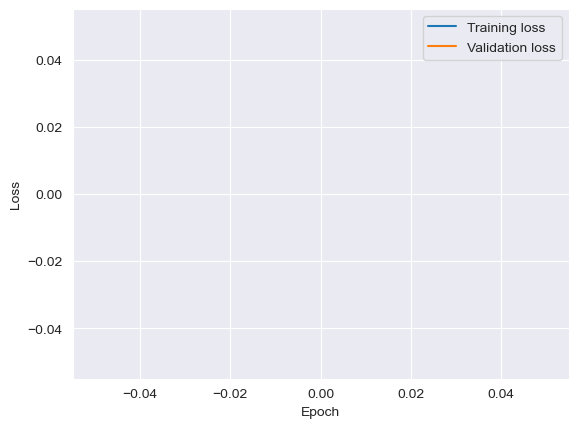

In [227]:
test_loss, test_acc = evaluate(model, test_loader, criterion)

print('Test Loss: {:.4f} Test Acc: {:.2f}%'.format(test_loss, test_acc*100))
import seaborn as sns
import matplotlib.pyplot as plt

train_loss, valid_loss = [], []

sns.set_style("darkgrid")
plt.plot(train_loss, label="Training loss")
plt.plot(valid_loss, label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [228]:
import time

start_time = time.time()

end_time = time.time()
print("CPU çalışma süresi:", end_time - start_time, "saniye")


CPU çalışma süresi: 0.00037288665771484375 saniye


In [ ]:
start_time = time.time()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs, labels = inputs.to(device), labels.to(device)

end_time = time.time()
print("GPU çalışma süresi:", end_time - start_time, "saniye")


In [3]:
from sklearn . metrics import accuracy_score
from sklearn . metrics import f1_score
from sklearn . metrics import precision_score
from sklearn . metrics import recall_score
y_true = []
y_pred = []
with torch . no_grad ():
    for data in test_loader :
        inputs , labels = data
        inputs , labels = inputs .to( device ), labels .to( device )
        outputs = model ( inputs )
        predicted = torch . argmax ( outputs , dim=1)
        y_true += labels . cpu (). tolist ()
        y_pred += predicted . cpu (). tolist ()
accuracy = accuracy_score (y_true , y_pred )
f1 = f1_score ( y_true , y_pred , average =’macro ’)
precision = precision_score (y_true , y_pred , average =’macro ’)
recall = recall_score ( y_true , y_pred , average =’macro ’)
print (’Accuracy :’, accuracy )
print (’F1 score :’, f1)
print (’Precision :’, precision )
print (’Recall :’, recall )

SyntaxError: invalid character '’' (U+2019) (550033787.py, line 16)

In [4]:

class RegularizedCrossEntropyLoss(nn.Module):
    def __init__(self, l1_lambda, l2_lambda):
        super(RegularizedCrossEntropyLoss, self).__init__()
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, output, target, model):
        l1_loss = 0
        l2_loss = 0
        for p in model.parameters():
            l1_loss += p.abs().sum()
            l2_loss += p.pow(2).sum()
        return self.criterion(output, target) + self.l1_lambda * l1_loss + self.l2_lambda * l2_loss

model = YourModel()

criterion = RegularizedCrossEntropyLoss(l1_lambda=0.001, l2_lambda=0.001)

optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(num_epochs):

    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target, model)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader.dataset)


NameError: name 'nn' is not defined